In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform, batch_size=64)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 28*28)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """

        dkl = - rho * torch.log(self.data_rho) - (1 - rho) * torch.log(1-self.data_rho)        
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [5]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [8]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [9]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.273850 32: 0.253484 64: 0.250040
Train Epoch: 1 [12800/50000 (26%)]	Losses 16: 0.268534 32: 0.245994 64: 0.247321
Train Epoch: 1 [25600/50000 (51%)]	Losses 16: 0.246976 32: 0.223937 64: 0.228021
Train Epoch: 1 [38400/50000 (77%)]	Losses 16: 0.221607 32: 0.197576 64: 0.203771
Train Epoch: 1 [12512/50000 (100%)]	Losses 16: 0.243991 32: 0.221373 64: 0.219812
Test set:
16: loss: 0.2363	pho_loss: 0.0032
32: loss: 0.2086	pho_loss: 0.0032
64: loss: 0.2123	pho_loss: 0.0032

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.224673 32: 0.198212 64: 0.200957
Train Epoch: 2 [12800/50000 (26%)]	Losses 16: 0.237479 32: 0.208117 64: 0.210161
Train Epoch: 2 [25600/50000 (51%)]	Losses 16: 0.236667 32: 0.202493 64: 0.197581
Train Epoch: 2 [38400/50000 (77%)]	Losses 16: 0.196033 32: 0.168744 64: 0.163751
Train Epoch: 2 [12512/50000 (100%)]	Losses 16: 0.203568 32: 0.172175 64: 0.165964
Test set:
16: loss: 0.2019	pho_loss: 0.0032
32: loss: 0.1740	pho_loss: 0.0032
64: los

Train Epoch: 17 [12800/50000 (26%)]	Losses 16: 0.114002 32: 0.089037 64: 0.074808
Train Epoch: 17 [25600/50000 (51%)]	Losses 16: 0.100703 32: 0.075894 64: 0.061919
Train Epoch: 17 [38400/50000 (77%)]	Losses 16: 0.113062 32: 0.086989 64: 0.072452
Train Epoch: 17 [12512/50000 (100%)]	Losses 16: 0.091569 32: 0.073958 64: 0.060983
Test set:
16: loss: 0.1115	pho_loss: 0.0032
32: loss: 0.0870	pho_loss: 0.0032
64: loss: 0.0723	pho_loss: 0.0032

Train Epoch: 18 [0/50000 (0%)]	Losses 16: 0.109118 32: 0.090421 64: 0.074192
Train Epoch: 18 [12800/50000 (26%)]	Losses 16: 0.114178 32: 0.089073 64: 0.073498
Train Epoch: 18 [25600/50000 (51%)]	Losses 16: 0.106284 32: 0.081653 64: 0.066344
Train Epoch: 18 [38400/50000 (77%)]	Losses 16: 0.102497 32: 0.080057 64: 0.066064
Train Epoch: 18 [12512/50000 (100%)]	Losses 16: 0.112602 32: 0.094315 64: 0.076374
Test set:
16: loss: 0.1092	pho_loss: 0.0032
32: loss: 0.0852	pho_loss: 0.0032
64: loss: 0.0705	pho_loss: 0.0032

Train Epoch: 19 [0/50000 (0%)]	Losses 1

In [12]:
for k in models:
    torch.save(models[k].state_dict(), 'relu_' + str(k) + '.pt')    

In [10]:
data, _ = next(iter(test_loader))
output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 6,  9,  4,  4,  5,  4,  6,  6,  3,  5,  8,  6,  5,  6,
         5,  4,  5,  6,  5,  3,  5,  6,  7,  5,  2,  5,  4,  5,
         4,  7,  3,  4,  6,  5,  3,  7,  3,  5,  3,  4,  4,  2,
         5,  1,  7,  5,  7,  4,  5,  6,  4,  5,  5,  5,  2,  4,
         8,  4,  5,  4,  8,  1,  5,  5])


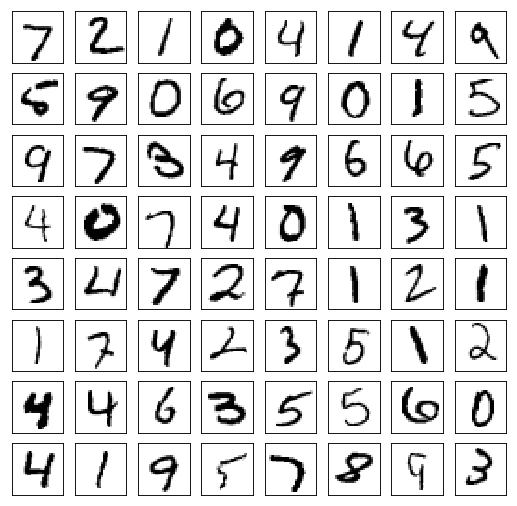

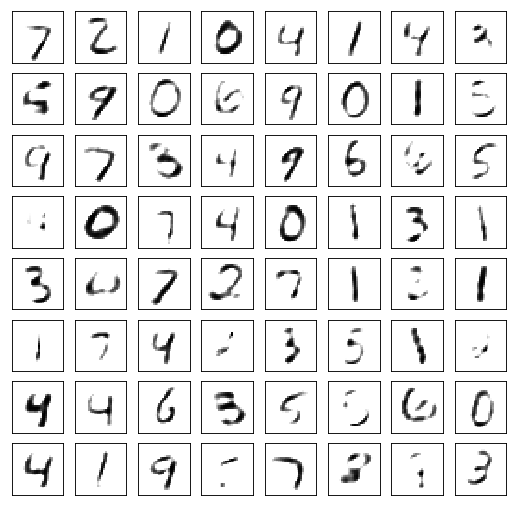

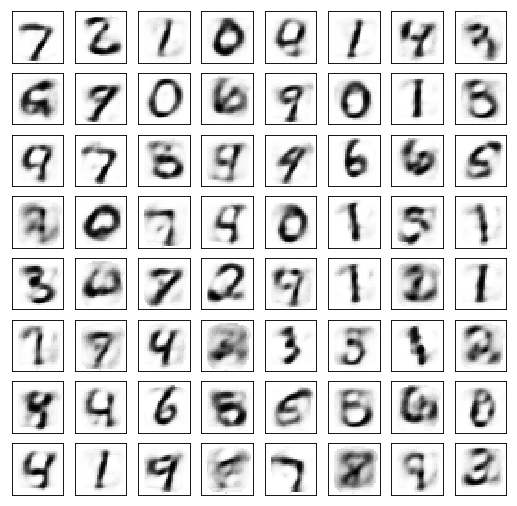

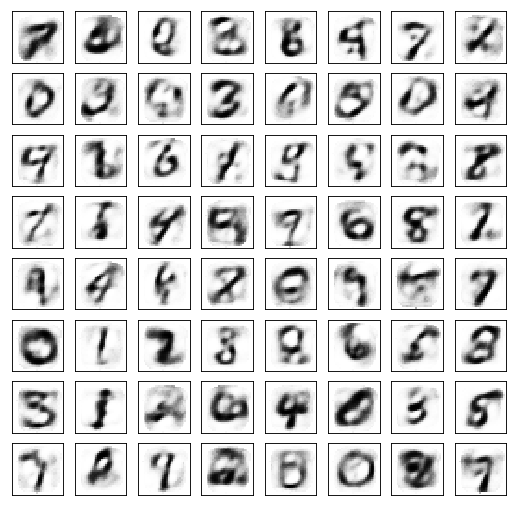

In [11]:
plot_mnist(data.data.numpy(), (8, 8))
plot_mnist(to_plot, (8, 8))

plot_mnist(f_to_plot, (8, 8))
plot_mnist(dec_to_plot, (8, 8))

In [13]:
the_model = Net(64)
the_model.load_state_dict(torch.load('relu_64.pt'))


In [14]:
data, _ = next(iter(test_loader))
output = the_model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = the_model.decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = the_model.E(data.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = the_model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 6,  9,  4,  4,  5,  4,  6,  6,  3,  5,  8,  6,  5,  6,
         5,  4,  5,  6,  5,  3,  5,  6,  7,  5,  2,  5,  4,  5,
         4,  7,  3,  4,  6,  5,  3,  7,  3,  5,  3,  4,  4,  2,
         5,  1,  7,  5,  7,  4,  5,  6,  4,  5,  5,  5,  2,  4,
         8,  4,  5,  4,  8,  1,  5,  5])


(64, 1, 28, 28)


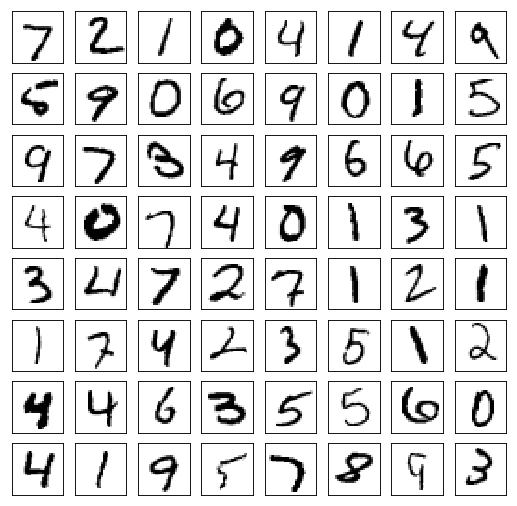

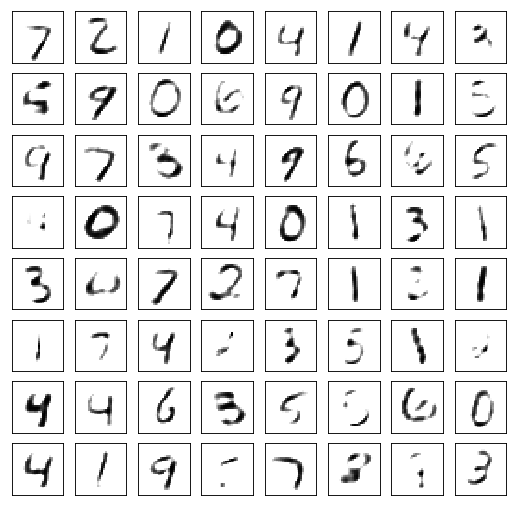

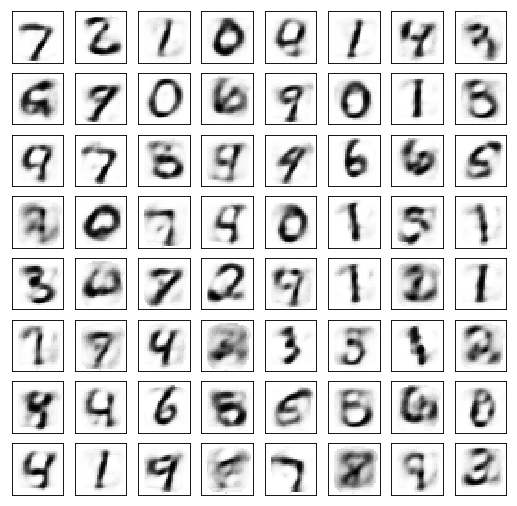

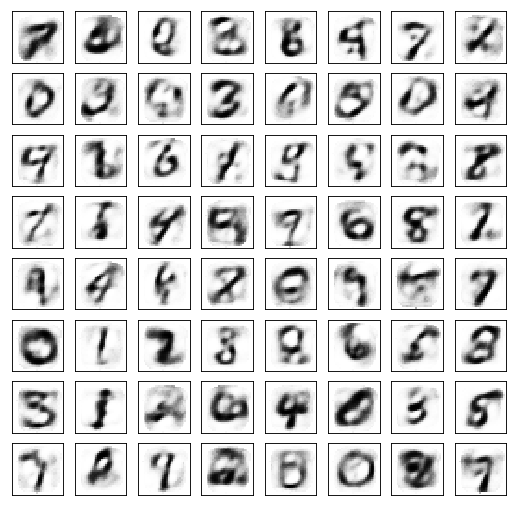

In [15]:
print(dec_to_plot.shape)

plot_mnist(data.data.numpy(), (8, 8))
plot_mnist(to_plot, (8, 8))

plot_mnist(f_to_plot, (8, 8))
plot_mnist(dec_to_plot, (8, 8))

In [16]:
w, _ = next(iter(test_loader))

In [17]:
w = nn.Parameter(w)
w_optim = optim.Adam(params=[w], lr=1e-1)

In [122]:
t = the_model.E(w.view(-1, 28*28))

In [18]:
for epoch in range(1, 1000):
    w_optim.zero_grad()
    t = the_model.E(w.view(-1, 28*28))    
    loss = F.mse_loss(t, torch.eye(64))
    loss.backward()
    w_optim.step()
    print(loss.item())

0.026984505355358124
0.018290523439645767
0.015326322987675667
0.014077370055019855
0.013293390162289143
0.01258761528879404
0.01184842735528946
0.011068079620599747
0.010305953212082386
0.009590553119778633
0.008911017328500748
0.008197396993637085
0.007490577641874552
0.006898436229676008
0.006441719830036163
0.006089227274060249
0.00582948187366128
0.0056306347250938416
0.005418879445642233
0.005175561178475618
0.004914998542517424
0.004608725197613239
0.004229062236845493
0.0038153580389916897
0.00347211305052042
0.0032502361573278904
0.0030802132096141577
0.002961973426863551
0.002922643208876252
0.002906187204644084
0.0028856326825916767
0.002854742808267474
0.0028019845485687256
0.0027112499810755253
0.002609028248116374
0.0025351466611027718
0.002450725296512246
0.0023494428023695946
0.002261966932564974
0.002158820629119873
0.002032456686720252
0.001931787352077663
0.0018593651475384831
0.0018295681802555919
0.0018219318008050323
0.0018159893807023764
0.0018036444671452045
0.0

0.0002467029553372413
0.00024669579579494894
0.00024668825790286064
0.0002466802252456546
0.00024667286197654903
0.0002466650621499866
0.0002466574660502374
0.00024665051023475826
0.0002466429432388395
0.00024663578369654715
0.000246628827881068
0.00024662158102728426
0.00024661465431563556
0.0002466073492541909
0.000246600218815729
0.00024659335031174123
0.00024658621987327933
0.00024657940957695246
0.00024657222093082964
0.0002465654688421637
0.00024655848392285407
0.0002465515863150358
0.0002465448633302003
0.00024653779109939933
0.000246531271841377
0.0002465246361680329
0.0002465179713908583
0.0002465111901983619
0.0002465046418365091
0.00024649815168231726
0.000246491254074499
0.00024648485123179853
0.0002464783610776067
0.0002464724821038544
0.0002464660501573235
0.00024645935627631843
0.00024645309895277023
0.0002464467252139002
0.00024644070072099566
0.0002464343560859561
0.00024642801145091653
0.00024642166681587696
0.00024641540949232876
0.0002464091230649501
0.0002464035351

0.0002452055923640728
0.000245203758822754
0.00024520177976228297
0.0002452002663630992
0.0002451986074447632
0.0002451969776302576
0.00024519534781575203
0.0002451938053127378
0.0002451920008752495
0.0002451902546454221
0.0002451889158692211
0.0002451874315738678
0.0002451858890708536
0.00024518463760614395
0.00024518303689546883
0.00024518155260011554
0.0002451798936817795
0.0002451780892442912
0.00024517648853361607
0.0002451749751344323
0.0002451736363582313
0.00024517197743989527
0.0002451706095598638
0.0002451691252645105
0.0002451676409691572
0.0002451659820508212
0.000245164439547807
0.0002451628679409623
0.0002451611217111349
0.0002451595210004598
0.0002451579493936151
0.0002451564359944314
0.00024515498080290854
0.00024515349650755525
0.00024515195400454104
0.0002451503532938659
0.00024514878168702126
0.0002451474138069898
0.0002451458422001451
0.00024514447432011366
0.0002451428445056081
0.00024514150572940707
0.00024513975949957967
0.0002451382752042264
0.000245136878220364

In [124]:
res = the_model.E(w.view(-1, 28*28))    
for i in range(0, 64):
    print(res[i][i].item())

# print(torch.eye(64))
# print(res)
# print(torch.eye(64) - res)



0.9984424710273743
0.9963849782943726
0.9963873624801636
0.9962171912193298
0.9980759620666504
0.9957613348960876
0.9959869980812073
0.9964166879653931
0.9969612956047058
0.9960569143295288
0.9989457726478577
0.9955741167068481
0.9960195422172546
0.9950516819953918
0.9968878626823425
0.9990319013595581
0.9990457892417908
0.9969449639320374
0.9998024106025696
0.9955744743347168
0.9952253103256226
0.9965967535972595
0.9952670335769653
0.9994674324989319
0.9972003698348999
0.9934641718864441
0.9958059787750244
0.9960118532180786
0.9991263747215271
0.9960458874702454
0.999024510383606
0.9970622658729553
0.9977834820747375
0.9959896206855774
0.9965313076972961
0.9959607720375061
0.9960504174232483
0.9992069602012634
0.9965319633483887
0.9979730248451233
0.9980175495147705
0.9959004521369934
0.9995515942573547
0.9966959953308105
0.9963770508766174
0.9966450333595276
0.99724942445755
0.9987789988517761
0.9956996440887451
0.99610435962677
0.9976740479469299
0.9960240125656128
0.995736598968505

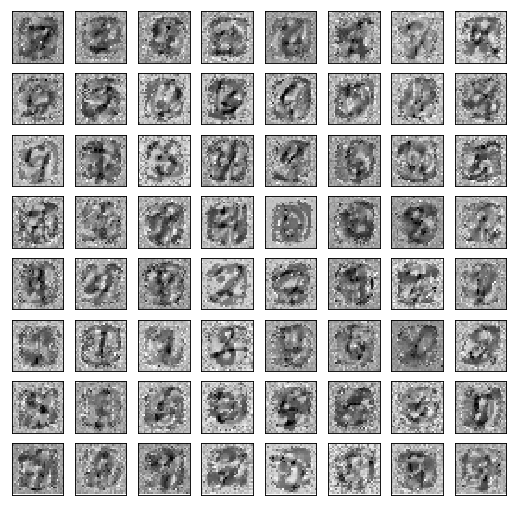

In [19]:
plot_mnist(w.data.numpy(), (8, 8))
